# Twitter account classification, no NLP

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data preprocessing

Read the csv files containing user data and inspect columns:

In [2]:
df_tradicionalbot_us = pd.read_csv('datasets_full/traditional_spambots_1/users.csv')

In [3]:
df_tradicionalbot_us.columns

Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'url', 'lang',
       'time_zone', 'location', 'default_profile', 'default_profile_image',
       'geo_enabled', 'profile_image_url', 'profile_banner_url',
       'profile_use_background_image', 'profile_background_image_url_https',
       'profile_text_color', 'profile_image_url_https',
       'profile_sidebar_border_color', 'profile_background_tile',
       'profile_sidebar_fill_color', 'profile_background_image_url',
       'profile_background_color', 'profile_link_color', 'utc_offset',
       'is_translator', 'follow_request_sent', 'protected', 'verified',
       'notifications', 'description', 'contributors_enabled', 'following',
       'created_at', 'timestamp', 'crawled_at', 'updated'],
      dtype='object')

In [4]:
df_genuine_us = pd.read_csv('datasets_full/genuine_accounts.csv/users.csv')

In [5]:
df_genuine_us.columns

Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'url', 'lang',
       'time_zone', 'location', 'default_profile', 'default_profile_image',
       'geo_enabled', 'profile_image_url', 'profile_banner_url',
       'profile_use_background_image', 'profile_background_image_url_https',
       'profile_text_color', 'profile_image_url_https',
       'profile_sidebar_border_color', 'profile_background_tile',
       'profile_sidebar_fill_color', 'profile_background_image_url',
       'profile_background_color', 'profile_link_color', 'utc_offset',
       'is_translator', 'follow_request_sent', 'protected', 'verified',
       'notifications', 'description', 'contributors_enabled', 'following',
       'created_at', 'timestamp', 'crawled_at', 'updated', 'test_set_1',
       'test_set_2'],
      dtype='object')

Drop unnecessary columns:

In [6]:
df_genuine_us = df_genuine_us.drop(['test_set_1','test_set_2'], axis=1)

Split train and test data for bots and human accounts:

In [7]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df_tradicionalbot_us, np.ones(df_tradicionalbot_us['id'].unique().shape[0]), random_state=42)
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(df_genuine_us, np.zeros(df_genuine_us['id'].unique().shape[0]), random_state=42)

X_train = pd.concat([X_train_b, X_train_g])
y_train = np.hstack([y_train_b, y_train_g])

X_test = pd.concat([X_test_b, X_test_g])
y_test = np.hstack([y_test_b, y_test_g])

Drop columns which are made entirely of NaN:

In [8]:
nanCols = (~df_tradicionalbot_us.isna()).sum()
nanCols = nanCols[nanCols == 0].index

X_train = X_train.drop(nanCols, axis=1)
X_test = X_test.drop(nanCols, axis=1)

Define functions to drop/transform columns for train and test sets together:

In [9]:
def drop_col(X_train, X_test, col):
    X_train.drop(col, axis=1, inplace=True)
    X_test.drop(col, axis=1, inplace=True)

def transform_bool(X_train, X_test, col):
    X_train['has_' + col] = (~X_train[col].isna()) * 1
    X_test['has_' + col] = (~X_test[col].isna()) * 1
    drop_col(X_train, X_test, col)

def transform_bool2(X_train, X_test, col, missing=0):
    X_train[col] = (X_train[col] != missing).astype(np.int64)
    X_test[col] = (X_test[col] != missing).astype(np.int64)

In [10]:
transform_bool(X_train, X_test, 'url')
transform_bool(X_train, X_test, 'location')
transform_bool(X_train, X_test, 'description')
X_train['geo_enabled'] = X_train['geo_enabled'].fillna(0)
X_test['geo_enabled'] = X_test['geo_enabled'].fillna(0)
drop_col(X_train, X_test, ['name', 'screen_name', 'statuses_count', 'profile_image_url', 'profile_background_image_url', 'created_at', 'timestamp', 'crawled_at', 'updated'])

Load and process tweets data. Drop tweets whose users are not in the dataset.

In [11]:
train_user_ids = {id: True for id in X_train['id']}

df_tradicionalbot_tw = pd.read_csv(
    'datasets_full/traditional_spambots_1/tweets.csv',
    usecols=["id","text","source","user_id","in_reply_to_user_id","num_hashtags","num_urls","num_mentions","timestamp"])
df_tradicionalbot_tw.fillna({'in_reply_to_screen_name':''}, inplace=True)
train_bot_mask = df_tradicionalbot_tw.user_id.apply(lambda id: train_user_ids.get(id, False))
df_tradicionalbot_tw_train = df_tradicionalbot_tw[train_bot_mask]
df_tradicionalbot_tw_test = df_tradicionalbot_tw[~train_bot_mask]

df_genuine_tw = pd.read_csv(
    'datasets_full/genuine_accounts.csv/tweets.csv',
    header=None, sep=',', quotechar='"', escapechar='\\', na_values=['nan'], keep_default_na=False,
    usecols=[0,1,2,3,6,19,20,21,22])
df_genuine_tw.columns = df_tradicionalbot_tw.columns
train_user_mask = df_genuine_tw.user_id.apply(lambda id: train_user_ids.get(id, False))
df_genuine_tw_train = df_genuine_tw[train_user_mask]
df_genuine_tw_test = df_genuine_tw[~train_user_mask]

tweets_train = pd.concat([df_tradicionalbot_tw_train, df_genuine_tw_train], ignore_index=True)
tweets_test = pd.concat([df_tradicionalbot_tw_test, df_genuine_tw_test], ignore_index=True)

has_tweets_train = {id:True for id in tweets_train['user_id']}
has_tweets_test = {id:True for id in tweets_test['user_id']}

X_train_tw_mask = X_train['id'].apply(lambda id: has_tweets_train.get(id, False))
X_test_tw_mask = X_test['id'].apply(lambda id: has_tweets_test.get(id, False))

X_train = X_train[X_train_tw_mask]
X_test = X_test[X_test_tw_mask]

y_train = y_train[X_train_tw_mask]
y_test = y_test[X_test_tw_mask]

In [12]:
transform_bool2(tweets_train, tweets_test, 'in_reply_to_user_id', missing=0)

Add average number of tweets that were marked as a reply to another user to the dataset:

In [13]:
X_train = X_train.join(
    (tweets_train[['user_id','in_reply_to_user_id']]
     .groupby('user_id')['in_reply_to_user_id']
     .mean()
     .rename('mean_reply_to_user_id')), on='id')
X_test = X_test.join(
    (tweets_test[['user_id','in_reply_to_user_id']]
     .groupby('user_id')['in_reply_to_user_id']
     .mean()
     .rename('mean_reply_to_user_id')), on='id')

Perform normalization on the appropriate features:

In [14]:
scalable_columns = ['followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'mean_reply_to_user_id']
scaler = MinMaxScaler().fit(X_train[scalable_columns])
X_train[scalable_columns] = scaler.transform(X_train[scalable_columns])
X_test[scalable_columns] = scaler.transform(X_test[scalable_columns])

# Model training and evaluation

## Training

Drop 'id' column, and train Logistic Regression and Random Forest models:

In [15]:
to_drop = ['id']
logistic_reg_model = LogisticRegression(C=1000000, max_iter=100000).fit(X_train.drop(to_drop, axis=1), y_train)
random_for_model = RandomForestClassifier().fit(X_train.drop(to_drop, axis=1), y_train)

## Evaluation

In [16]:
print("Logistic Regression testing accuracy: ", logistic_reg_model.score(X_test.drop(to_drop, axis=1), y_test))
print("                            precision: ", metrics.precision_score(y_test, logistic_reg_model.predict(X_test.drop(to_drop, axis=1))))
print("                            recall: ", metrics.recall_score(y_test, logistic_reg_model.predict(X_test.drop(to_drop, axis=1))))
print("")
print("Logistic Regression training accuracy: ", logistic_reg_model.score(X_train.drop(to_drop, axis=1), y_train))
print("                             precision: ", metrics.precision_score(y_train, logistic_reg_model.predict(X_train.drop(to_drop, axis=1))))
print("                             recall: ", metrics.recall_score(y_train, logistic_reg_model.predict(X_train.drop(to_drop, axis=1))))

Logistic Regression testing accuracy:  0.9762989972652689
                            precision:  0.9516129032258065
                            recall:  0.944

Logistic Regression training accuracy:  0.9769487412799515
                             precision:  0.9457671957671958
                             recall:  0.9533333333333334


In [17]:
print("Random Forest testing accuracy: ", random_for_model.score(X_test.drop(to_drop, axis=1), y_test))
print("                      precision: ", metrics.precision_score(y_test, random_for_model.predict(X_test.drop(to_drop, axis=1))))
print("                      recall: ", metrics.recall_score(y_test, random_for_model.predict(X_test.drop(to_drop, axis=1))))
print("")
print("Random Forest training accuracy: ", random_for_model.score(X_train.drop(to_drop, axis=1), y_train))
print("                       precision: ", metrics.precision_score(y_train, random_for_model.predict(X_train.drop(to_drop, axis=1))))
print("                       recall: ", metrics.recall_score(y_train, random_for_model.predict(X_train.drop(to_drop, axis=1))))

Random Forest testing accuracy:  0.9899726526891522
                      precision:  0.9799196787148594
                      recall:  0.976

Random Forest training accuracy:  1.0
                       precision:  1.0
                       recall:  1.0


These are the features with larger weights:

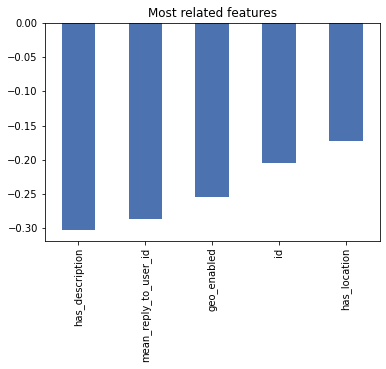

In [18]:
train_cor = X_train.corrwith(pd.Series(y_train))
strong_feats = train_cor[train_cor.abs() > 0.1]

ax = strong_feats.sort_values().plot.bar()
ax.set_title('Most related features')
plt.savefig('Most_related_features.png')

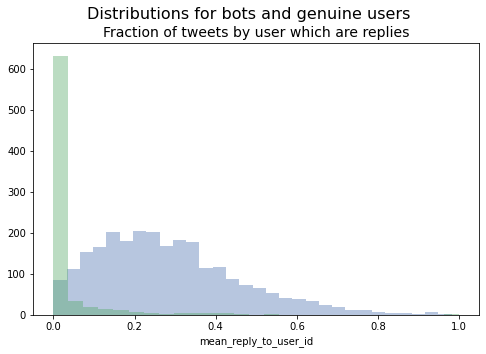

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

fig.suptitle('Distributions for bots and genuine users', fontsize=16)
sns.distplot(X_train[y_train==0]['mean_reply_to_user_id'], kde=False, ax=ax, label='genuine')
sns.distplot(X_train[y_train==1]['mean_reply_to_user_id'], kde=False, ax=ax, label='bot')
ax.set_title('Fraction of tweets by user which are replies', fontsize=14)


plt.savefig('Feature_distributions.png')
